In [6]:
from __future__ import print_function, division
import os
import torch
import random
from typing import Iterator, List, Callable, Tuple, Literal
from functools import partial
import warnings
from math import *
import zipfile
from tqdm import tqdm
from PIL import Image

# Sklearn
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Numpy
import numpy as np
# Pandas
import pandas as pd

# PyTorch packages
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data import RandomSampler, Sampler
from torchvision import transforms, utils, datasets
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn as nn
import torch.optim as optim

# matplotlib
from matplotlib import rc, cm
rc('animation', html='jshtml')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
%matplotlib notebook
#warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

import time

In [7]:
class NSLKDD_Dataset(Dataset):
    def __init__(self, features, labels=None):
        """
        features: numpy array or tensor of shape (N, input_size)
        labels: numpy array or tensor of shape (N, ) [Optional for training]
        """
        self.data = torch.tensor(features, dtype=torch.float32)
        if labels is not None:
            self.labels = torch.tensor(labels, dtype=torch.float32)
        else:
            self.labels = None

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.labels is not None:
            label = self.labels[idx]
            return sample, label
        else:
            # If no labels (training mode), just return sample twice or sample + dummy
            return sample, torch.zeros(1)

    def __len__(self):
        return len(self.data)

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=8, device='cpu'):
        super().__init__()
        self.device = device
        
        # --- ENCODER ---
        # "Input vectors are compressed into m numbers of neurons" 
        # Eq (4): h = s(Wx + b)
        # Strictly Input (122) -> Hidden (8)
        self.encoder = nn.Linear(input_size, hidden_size)
        
        # --- DECODER ---
        # "Hidden representation is then decoded back to original input space" 
        # Eq (5): x' = s(Wh + b)
        # Strictly Hidden (8) -> Output (122)
        self.decoder = nn.Linear(hidden_size, input_size)
        
        # Activation: "We select sigmoid function" 
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = x.to(self.device)
        x = x.float()
        
        # 1. Encode: Project input to the 8-neuron hidden layer
        # Apply Sigmoid as per Eq (4)
        hidden = self.activation(self.encoder(x))
        
        # 2. Decode: Reconstruct the data from the 8 neurons
        # Apply Sigmoid as per Eq (5)
        reconstruction = self.activation(self.decoder(hidden))
        
        return reconstruction

In [23]:
# --- DATA PROCESSING FUNCTION (Unchanged) ---
def load_and_process_strict(train_path: str, test_path: str, protocol: Literal['tcp','udp','icmp'], use_one_hot: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    col_names = ["duration","protocol_type","service","flag","src_bytes",
        "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
        "logged_in","num_compromised","root_shell","su_attempted","num_root",
        "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
        "is_host_login","is_guest_login","count","srv_count","serror_rate",
        "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
        "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
        "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
        "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

    df_train = pd.read_csv(train_path, header=None, names=col_names)
    df_test = pd.read_csv(test_path, header=None, names=col_names)

    df_total = pd.concat([df_train, df_test], ignore_index=True)
    df_total = df_total[df_total['protocol_type'] == protocol].copy()

    # 0=Normal, 1=Attack
    df_total['binary_label'] = df_total['label'].apply(lambda x: 0 if x == 'normal' else 1)

    df_normal = df_total[df_total['binary_label'] == 0].copy()
    df_attack = df_total[df_total['binary_label'] == 1].copy()

    drop_cols = ['label', 'binary_label', 'difficulty', 'protocol_type']
    X_normal_raw = df_normal.drop(columns=drop_cols)
    X_attack_raw = df_attack.drop(columns=drop_cols)

    numerical_cols = X_normal_raw.select_dtypes(exclude=['object']).columns.tolist()

    if use_one_hot:
      categorical_cols = X_normal_raw.select_dtypes(include=['object']).columns.tolist()
      preprocessor = ColumnTransformer(
          transformers=[
              ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
              ('num', MinMaxScaler(), numerical_cols)
          ]
      )
    else: # If one-hot encoding is not used, only scale numerical features
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', MinMaxScaler(), numerical_cols)
            ]
        )

    # Fit only on normal data (standard practice and implied by paper context)
    preprocessor.fit(X_normal_raw)

    X_normal_processed = preprocessor.transform(X_normal_raw)
    X_attack_processed = preprocessor.transform(X_attack_raw)

    print(f"Protocol {protocol}: Normal Samples={len(X_normal_processed)}, Attack Samples={len(X_attack_processed)}")
    return X_normal_processed, X_attack_processed

In [16]:
TRAIN_PATH = '/kaggle/input/nslkdd/KDDTrain+.txt' 
TEST_PATH = '/kaggle/input/nslkdd/KDDTest+.txt'
BATCH_SIZE = 32
NUM_EPOCHS = 50 # Reduced for speed in demo, set to 50+ for real results
LR = 0.001
K_FOLDS = 10

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

start_time = time.time()

# Iterate over protocols
for protocol in ['tcp', 'udp', 'icmp']:
# for protocol in ['udp']:
    print(f"\nProcessing {protocol}...")
    
    # Load SEPARATE arrays (The fix)
    X_normal, X_attack = load_and_process_strict(TRAIN_PATH, TEST_PATH, protocol)
    
    # Create indices for splitting
    normal_indices = np.arange(len(X_normal))
    attack_indices = np.arange(len(X_attack))
    np.random.shuffle(normal_indices)
    np.random.shuffle(attack_indices)
    
    # Split into 10 chunks
    normal_chunks = np.array_split(normal_indices, K_FOLDS)
    attack_chunks = np.array_split(attack_indices, K_FOLDS)
    
    accuracies = []
    aucs = []

    for fold in range(K_FOLDS):
        print('=' * 40)
        print(f"Fold {fold + 1}/10")
        print('=' * 40)
        # --- A. TRAIN SET: 9/10ths of NORMAL ONLY ---
        train_idx = np.concatenate([normal_chunks[i] for i in range(K_FOLDS) if i != fold])
        X_train = X_normal[train_idx]
        y_train = np.zeros(len(X_train)) # All normal
        
        # --- B. TEST SET: 1/10th Normal + 1/10th Attack ---
        X_test_normal = X_normal[normal_chunks[fold]]
        X_test_attack = X_attack[attack_chunks[fold]]
        
        X_test = np.concatenate([X_test_normal, X_test_attack])
        y_test = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(X_test_attack))])
        
        # Loaders
        train_loader = DataLoader(NSLKDD_Dataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(NSLKDD_Dataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)
        
        # --- C. TRAIN MODEL ---
        model = Autoencoder(X_train.shape[1], hidden_size=8, device=device).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        
        model.train()
        for epoch in range(NUM_EPOCHS):
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
            elif epoch == 0:
                print(f"Epoch 1/{NUM_EPOCHS}")
            for features, _ in train_loader:
                optimizer.zero_grad()
                outputs = model(features)

                loss = criterion(outputs, features.to(device))

                loss.backward()
                optimizer.step()
                
        # --- D. EVALUATE ---
        model.eval()
        all_scores, all_labels = [], []
        with torch.no_grad():
            for features, labels in test_loader:
                features = features.to(device)
                outputs = model(features)
                mse = torch.mean(torch.pow(features - outputs, 2), dim=1)
                all_scores.extend(mse.cpu().tolist())
                all_labels.extend(labels.tolist())

        # Metrics
        fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        
        # Youden's J for Accuracy
        best_thresh = thresholds[np.argmax(tpr - fpr)]
        preds = [1 if s > best_thresh else 0 for s in all_scores]
        acc = accuracy_score(all_labels, preds)
        
        aucs.append(roc_auc)
        accuracies.append(acc)

    print(f"AVG AUC: {np.mean(aucs):.4f} | AVG ACC: {np.mean(accuracies):.4f}")
    print(f"MAX AUC: {np.max(aucs):.4f} | MAX ACC: {np.max(accuracies):.4f}")

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")


Processing tcp...
Protocol tcp: Normal Samples=61442, Attack Samples=60127
Input Features expanded from 40 to 68
Fold 1/10
Epoch 1/50
Epoch 10/50
Epoch 20/50
Epoch 30/50
Epoch 40/50
Epoch 50/50
Fold 2/10
Epoch 1/50
Epoch 10/50
Epoch 20/50
Epoch 30/50
Epoch 40/50
Epoch 50/50
Fold 3/10
Epoch 1/50
Epoch 10/50
Epoch 20/50
Epoch 30/50
Epoch 40/50
Epoch 50/50
Fold 4/10
Epoch 1/50
Epoch 10/50
Epoch 20/50
Epoch 30/50
Epoch 40/50
Epoch 50/50
Fold 5/10
Epoch 1/50
Epoch 10/50
Epoch 20/50
Epoch 30/50
Epoch 40/50
Epoch 50/50
Fold 6/10
Epoch 1/50
Epoch 10/50
Epoch 20/50
Epoch 30/50
Epoch 40/50
Epoch 50/50
Fold 7/10
Epoch 1/50
Epoch 10/50
Epoch 20/50
Epoch 30/50
Epoch 40/50
Epoch 50/50
Fold 8/10
Epoch 1/50
Epoch 10/50
Epoch 20/50
Epoch 30/50
Epoch 40/50
Epoch 50/50
Fold 9/10
Epoch 1/50
Epoch 10/50
Epoch 20/50
Epoch 30/50
Epoch 40/50
Epoch 50/50
Fold 10/10
Epoch 1/50
Epoch 10/50
Epoch 20/50
Epoch 30/50
Epoch 40/50
Epoch 50/50
AVG AUC: 0.9878 | AVG ACC: 0.9578
MAX AUC: 0.9889 | MAX ACC: 0.9609

Proces


--- Processing TCP ---
Protocol tcp: Normal Samples=61442, Attack Samples=60127
Fitting PCA on tcp Normal data...


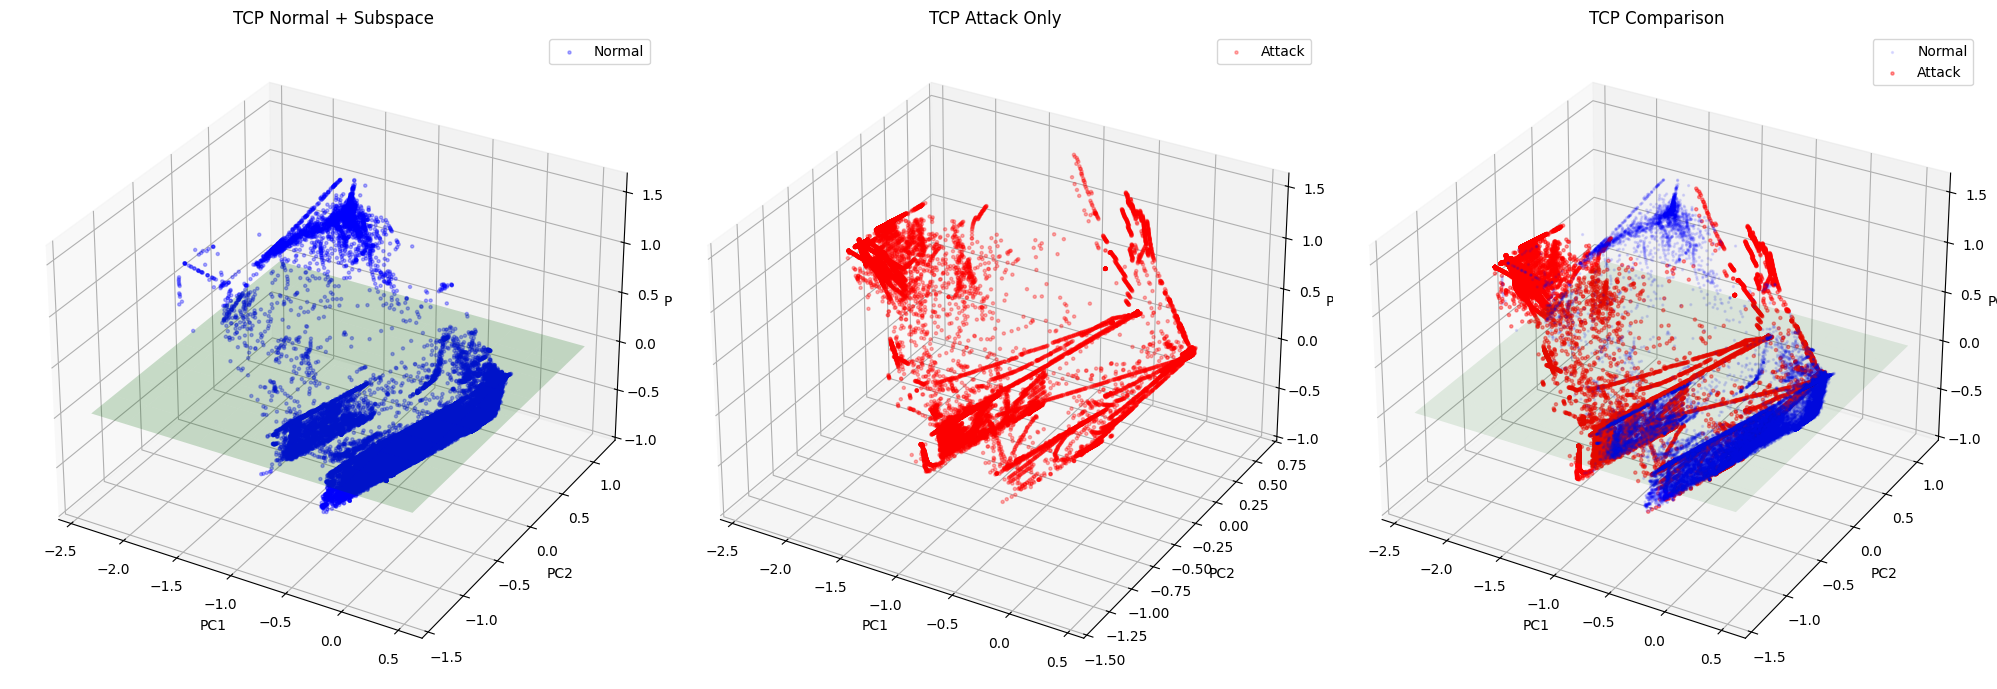


--- Processing UDP ---
Protocol udp: Normal Samples=14210, Attack Samples=3404
Fitting PCA on udp Normal data...


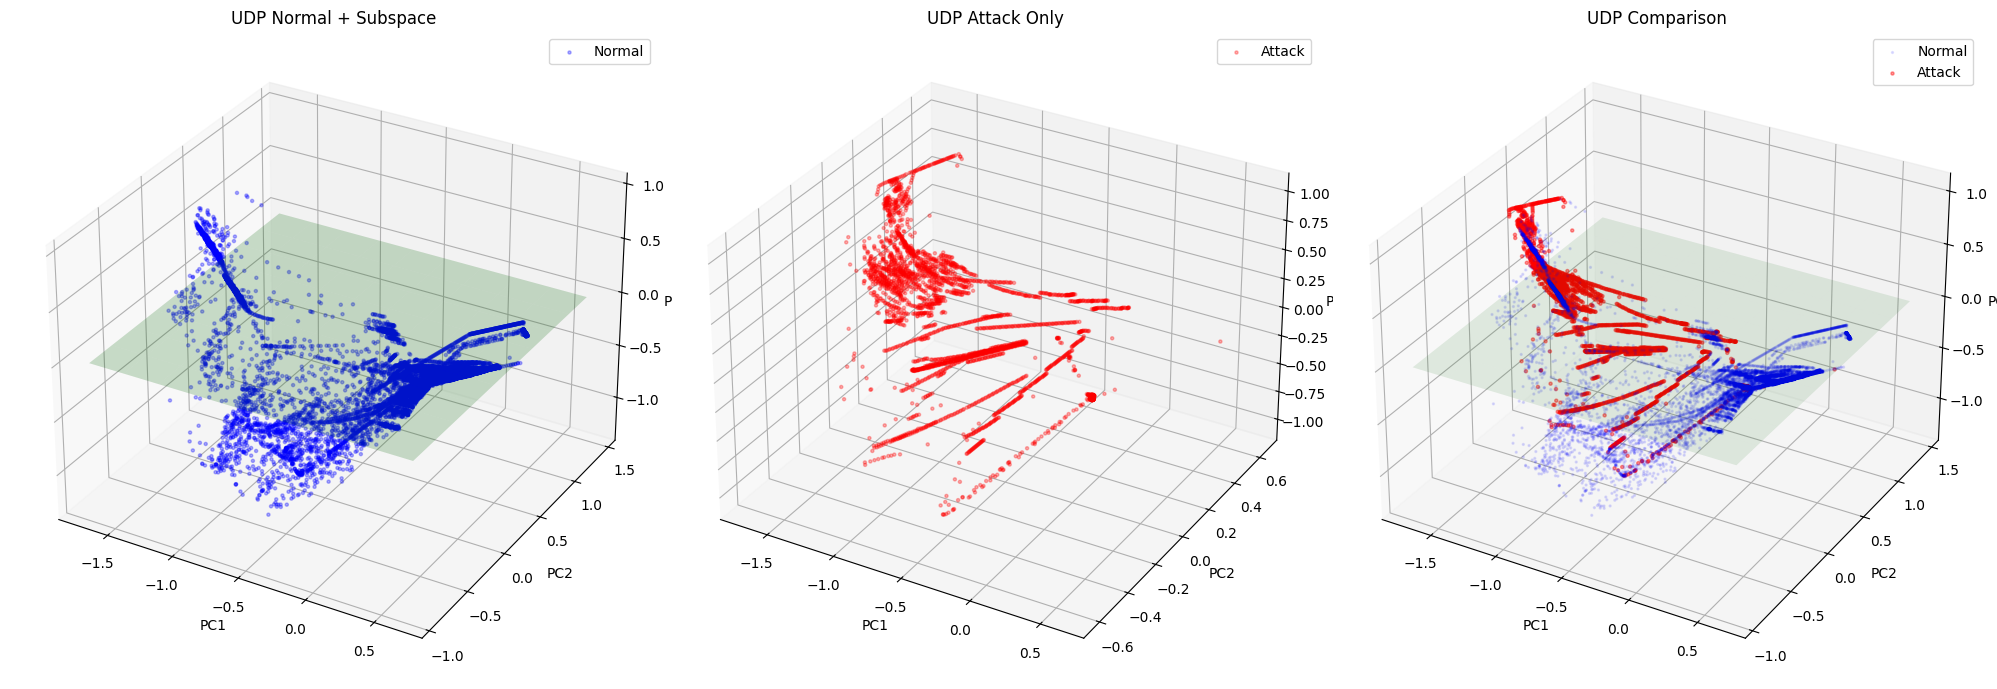


--- Processing ICMP ---
Protocol icmp: Normal Samples=1402, Attack Samples=7932
Fitting PCA on icmp Normal data...


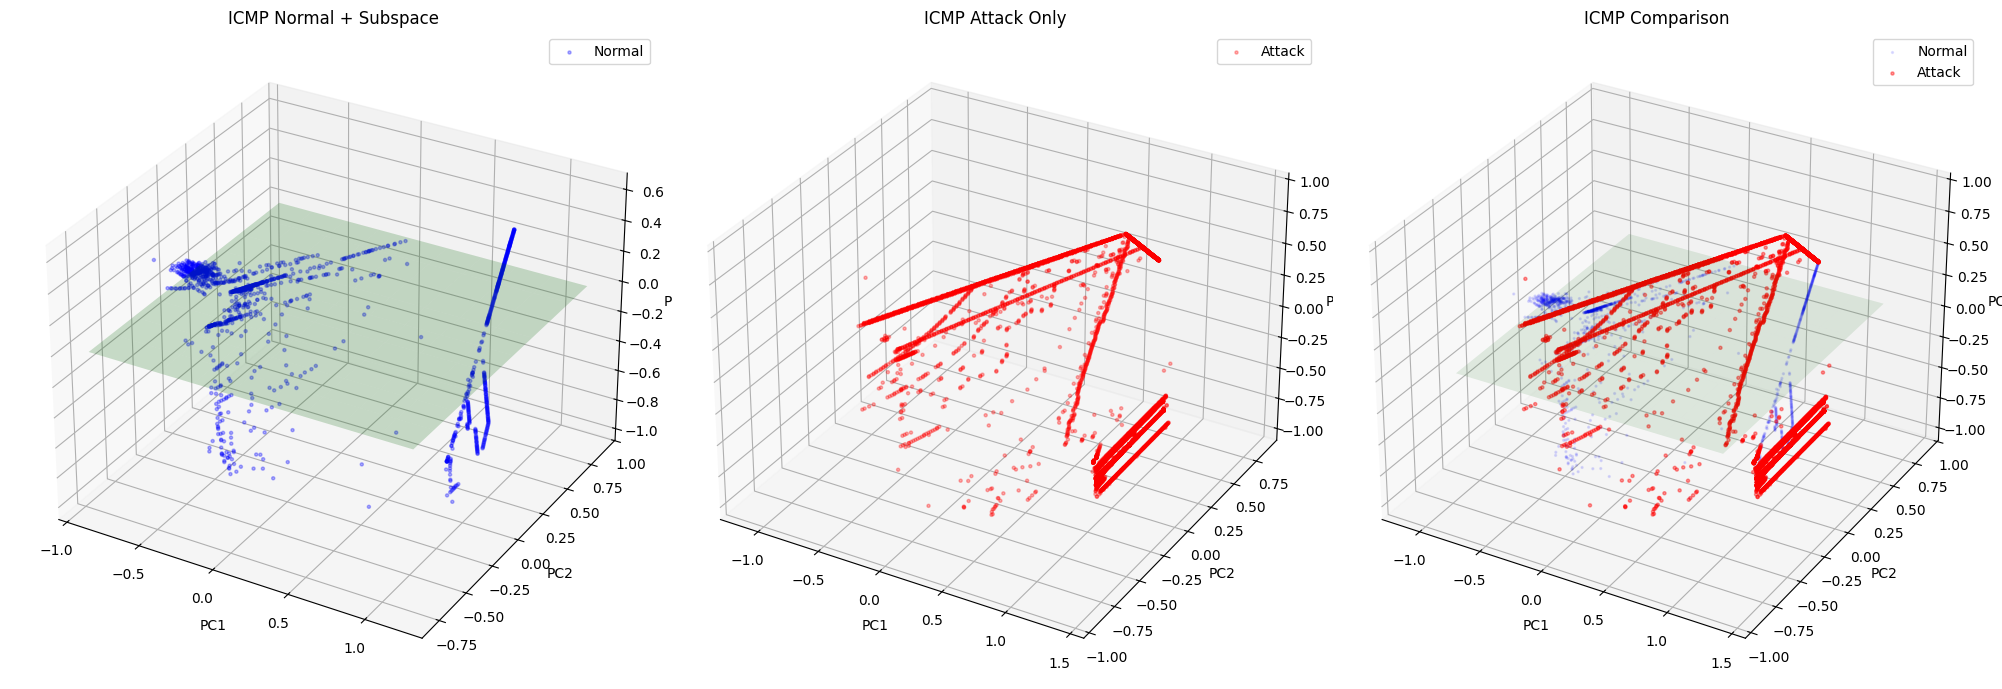

In [38]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from typing import Tuple, Literal

# --- CONFIGURATION ---
TRAIN_PATH = '/kaggle/input/nslkdd/KDDTrain+.txt' 
TEST_PATH = '/kaggle/input/nslkdd/KDDTest+.txt'
PROTOCOL = 'tcp'
SAMPLE_SIZE = 130000  # Points to plot per class

for PROTOCOL in ('tcp', 'udp', 'icmp'):
    # 1. Load Data
    try:
        print(f"\n--- Processing {PROTOCOL.upper()} ---")
        X_normal, X_attack = load_and_process_strict(TRAIN_PATH, TEST_PATH, PROTOCOL, False)
    except FileNotFoundError:
        print(f"File not found. Please check paths: {TRAIN_PATH}")
        break

    if len(X_normal) == 0:
        print(f"No data found for {PROTOCOL}. Skipping.")
        continue

    # 2. Sample Data
    np.random.seed(42)
    idx_normal = np.random.choice(len(X_normal), min(len(X_normal), SAMPLE_SIZE), replace=False)
    idx_attack = np.random.choice(len(X_attack), min(len(X_attack), SAMPLE_SIZE), replace=False)
    
    X_vis_normal = X_normal[idx_normal]
    X_vis_attack = X_attack[idx_attack]
    
    # 3. Fit PCA
    print(f"Fitting PCA on {PROTOCOL} Normal data...")
    pca = PCA(n_components=3)
    pca.fit(X_normal)
    
    X_pca_normal = pca.transform(X_vis_normal)
    X_pca_attack = pca.transform(X_vis_attack)
    
    # 4. Generate 3D Plots
    fig = plt.figure(figsize=(20, 7))
    
    # Meshgrid for the plane
    x_min, x_max = X_pca_normal[:, 0].min(), X_pca_normal[:, 0].max()
    y_min, y_max = X_pca_normal[:, 1].min(), X_pca_normal[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))
    zz = np.zeros_like(xx)
    
    # --- SUBPLOTS ---
    # Subplot 1: Normal
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(X_pca_normal[:,0], X_pca_normal[:,1], X_pca_normal[:,2], c='blue', alpha=0.3, s=5, label='Normal')
    ax1.plot_surface(xx, yy, zz, alpha=0.2, color='green')
    ax1.set_title(f'{PROTOCOL.upper()} Normal + Subspace')
    
    # Subplot 2: Attack
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(X_pca_attack[:,0], X_pca_attack[:,1], X_pca_attack[:,2], c='red', alpha=0.3, s=5, label='Attack')
    ax2.set_title(f'{PROTOCOL.upper()} Attack Only')
    
    # Subplot 3: Combined
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(X_pca_normal[:,0], X_pca_normal[:,1], X_pca_normal[:,2], c='blue', alpha=0.1, s=2, label='Normal')
    ax3.scatter(X_pca_attack[:,0], X_pca_attack[:,1], X_pca_attack[:,2], c='red', alpha=0.4, s=5, label='Attack')
    ax3.plot_surface(xx, yy, zz, alpha=0.1, color='green')
    ax3.set_title(f'{PROTOCOL.upper()} Comparison')

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.legend()

    plt.tight_layout()
    plt.show()